<center> <h1>Fatalities in car accidents by miles driven</h1></center>

The problem we are going to take into consideration is fatalities in car accidents correspoding to miles driven each year. We have chosen data from 1930-1960 since it would be more accurate and also covers the time of WWII which caused a significant drops in miles driven and will provide a variety of data used.

The real reason to creat such a model is to analyze and predict future years and possibly come up with some solutions that could guarantee us better safety and less fatal accidents in the future.

In [3]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Below you can see a sample of the data we had downloaded.

In [4]:
df = pd.read_csv("cars_fatalities.csv")
df.head()

,Year,Fatalities,Vehicles,Miles
0,1930,32900,26.7,206
1,1931,33700,26.1,216
2,1932,29500,24.4,200
3,1933,31363,24.2,201
4,1934,36101,25.3,216


We have chosen data from NSC injury facts since they provide reliable data. Also, we have decided to focus on a country of USA and as we mentioned before years 1930-1960.

https://injuryfacts.nsc.org/motor-vehicle/historical-fatality-trends/deaths-and-rates/
 

The data we had downloaded contains Fatalities, Miles driven and Number of vehicle for each year in the USA. This set of data allowed us to creat such model.

The chart before presents the data over the years. The drop in fatalities during WWII is clearly visible.

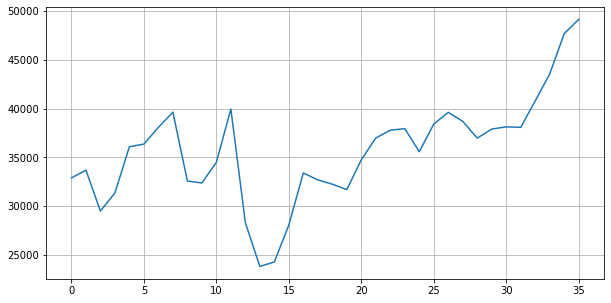

In [5]:
df['Fatalities'].plot(figsize=(10,5), grid=True)
plt.show()


Below, a histogram of fatalities in the years of 1930-1960 can be seen.

<AxesSubplot:>

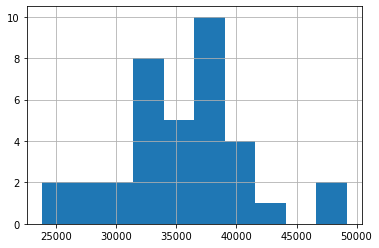

In [6]:
df["Fatalities"].hist(bins =10)

<h1>FIRST MODEL</h1>

For the first model, we have chosen linear regression. Firstly in our project, we tried to observe the data and come up with some solutions. We have noticed a linear dependence between the two factor which are fatalities and miles driven. Becuase of this, we decided to proceed with the linear regression model.

Since the data for USA may have a little correlation with data in Poland, after a bit of consideration, we looked at the priors this way. Around 10 people die daily in Poland in car accidents, that makes 3650 people a year in, a 38mln of a population, country. In USA live around 9 times more people. Taking  all of that, we come up with around 33000 people dying each year in car accidents in USA. This prior was used in first model.

First of all, we are creating prior check. Our simple model generated the data based on our priors. After that we tried to figure out if that is the right choice.

In [7]:
model1_ppc=CmdStanModel(stan_file='first_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [8]:
R = 1000
sim=model1_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [9]:
sim = sim.draws_pd()

We can observe on the two histograms that the data is similar and we had reached a satisfying level.

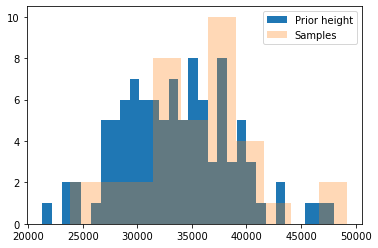

In [10]:
sim['deaths'][0:100].hist(bins=30)
df['Fatalities'].hist(alpha=0.3)
plt.legend(['Prior height', 'Samples'])
plt.grid()
plt.show()

After this, we proceeded to posterior analysis. In the next few steps we compiled the model, sampled it and tried to show some data.

In [11]:
model_1_fit=CmdStanModel(stan_file='first_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [12]:
data_fit={'N':len(df), 'Miles':df['Miles'], 'deaths':df['Fatalities']}
fit=model_1_fit.sample(data=data_fit,seed=29042020)
fit_car_lin = fit

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [13]:
fit_car_lin.diagnose()

'Processing csv files: C:\\Users\\aswat\\AppData\\Local\\Temp\\tmp_ju1um6i\\first_fit-20220621232846_1.csv, C:\\Users\\aswat\\AppData\\Local\\Temp\\tmp_ju1um6i\\first_fit-20220621232846_2.csv, C:\\Users\\aswat\\AppData\\Local\\Temp\\tmp_ju1um6i\\first_fit-20220621232846_3.csv, C:\\Users\\aswat\\AppData\\Local\\Temp\\tmp_ju1um6i\\first_fit-20220621232846_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

---------------------------\\----------------------------------------

No issues with the sampling had occured. We had recived data that is presented below.

   alpha ~ normal(33000,6000)

   beta ~ lognormal(0,1)

   sigma ~ exponential(0.08)

The alpha, beta, sigma parameters were chosen as above. We had previously explained the choice of alpha. For beta it was a trial and error method, lognormal(0,1) turned our slightly better than normal(0,1). Since the data we had chosen can be quite vary we decided to choose exp(0.08) to have it vary a lot.

Below, the values generated by the model can be observed.

In [14]:
beta = fit.stan_variable('beta')
alpha = fit.stan_variable('alpha')
az.summary(fit, var_names=['beta','sigma','alpha'],round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
beta,18.45,1.26,16.13,20.95
sigma,1635.68,75.52,1491.33,1775.18
alpha,27457.68,616.52,26328.60,28636.70


Below, we can observe mean samples for all of the datapoints.

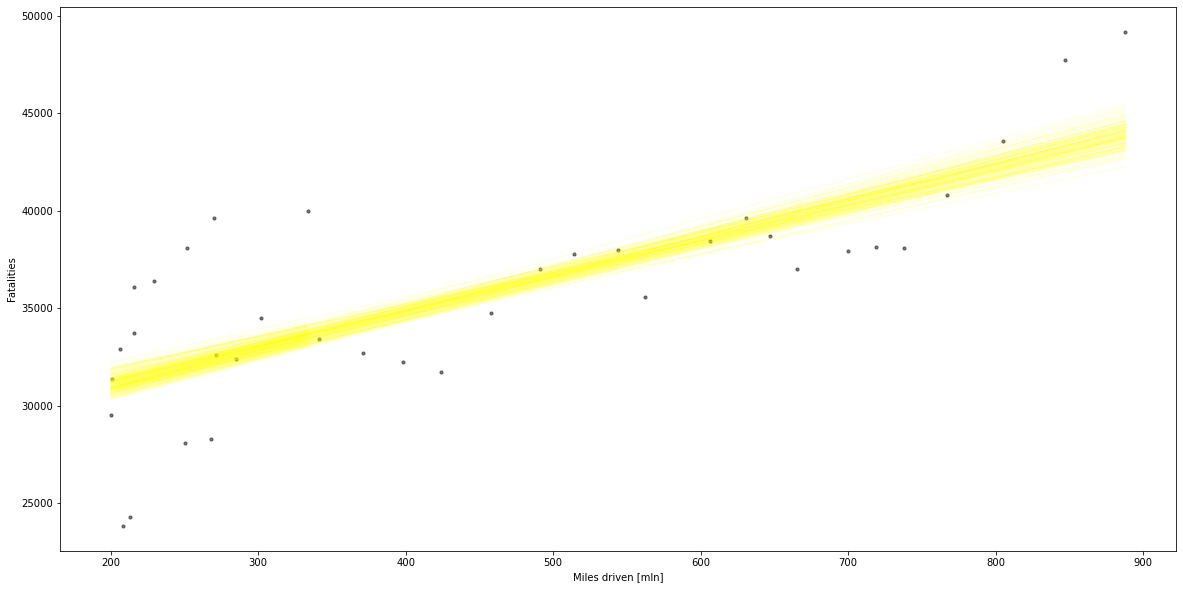

In [15]:
fig, axes = plt.subplots(1,1,figsize=(20,10))
for i in range(100):
    axes.plot(df.Miles,
    alpha[i]+beta[i]*df.Miles, alpha=0.1, color='yellow')
plt.xlabel("Miles driven [mln]")
plt.ylabel("Fatalities")
axes.scatter(df.Miles, df.Fatalities, color='black',alpha=0.5,s=10)

    

Below we can see how model reacts to miles and what values are returned. We can see that the chart is similar to the actual data throughout the years.

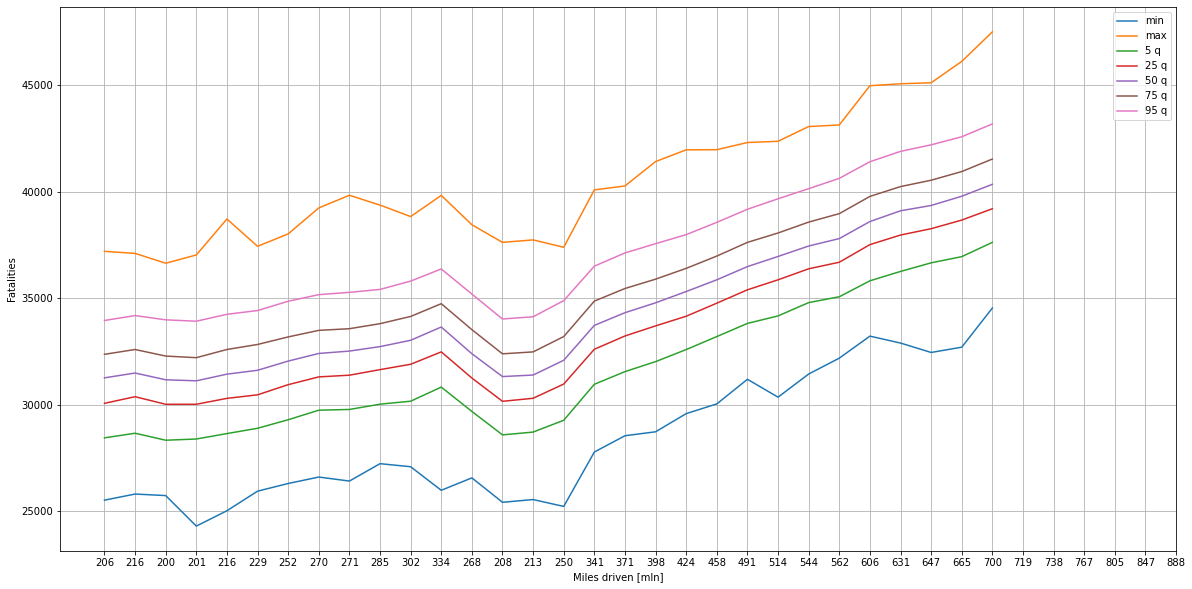

In [16]:
fit_height = fit.draws_pd()
fit_height = fit_height.loc[:,'death[1]':'death[30]']
data2 = {'min' : fit_height.min(),
        'max' : fit_height.max(),
        '5 q' : fit_height.quantile(0.05),
        '25 q' : fit_height.quantile(0.25),
        '50 q' : fit_height.quantile(0.5),
        '75 q' : fit_height.quantile(0.75),
        '95 q' : fit_height.quantile(0.95)}

fit_data = pd.DataFrame(data2)
fit_data.plot(figsize=(20,10))
plt.xlabel("Miles driven [mln]")
plt.ylabel("Fatalities")
default_x_ticks = range(len(df.Miles))
plt.xticks(default_x_ticks, df.Miles)
plt.grid()


Since the results of the model looked promising, we attempted to predict the future years. For the year 1961, the numer of miles driven is 719. We combined that with the alpha and beta recived from the model above.

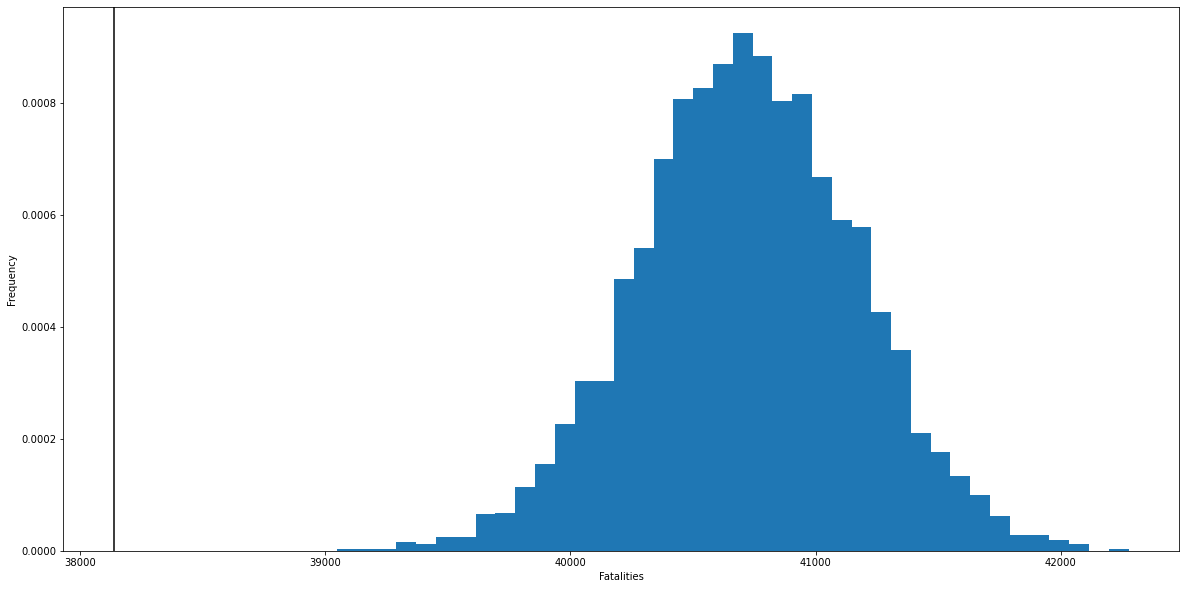

In [17]:
mu3500 = alpha+beta*(719)
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.hist(mu3500,bins=40,density=True)
plt.axvline(x = 38137, color = 'black', label = 'Actual data for 201mln miles')
plt.xlabel("Fatalities")
plt.ylabel("Frequency")
plt.show()

Let's take a closer look. Histogram presented above shows us generated by the model data of prdeicted deaths for year 1961. Black line is the actual value. We can see that the results recived are quite satisfying.

LINEAR MODEL HISTOGRAMS WITH ACTUAL VALUE

To have the closest look to what we had recived, we ploted histograms for each year of 1930-1960 and marked the actual value with a black line just as we did above. 

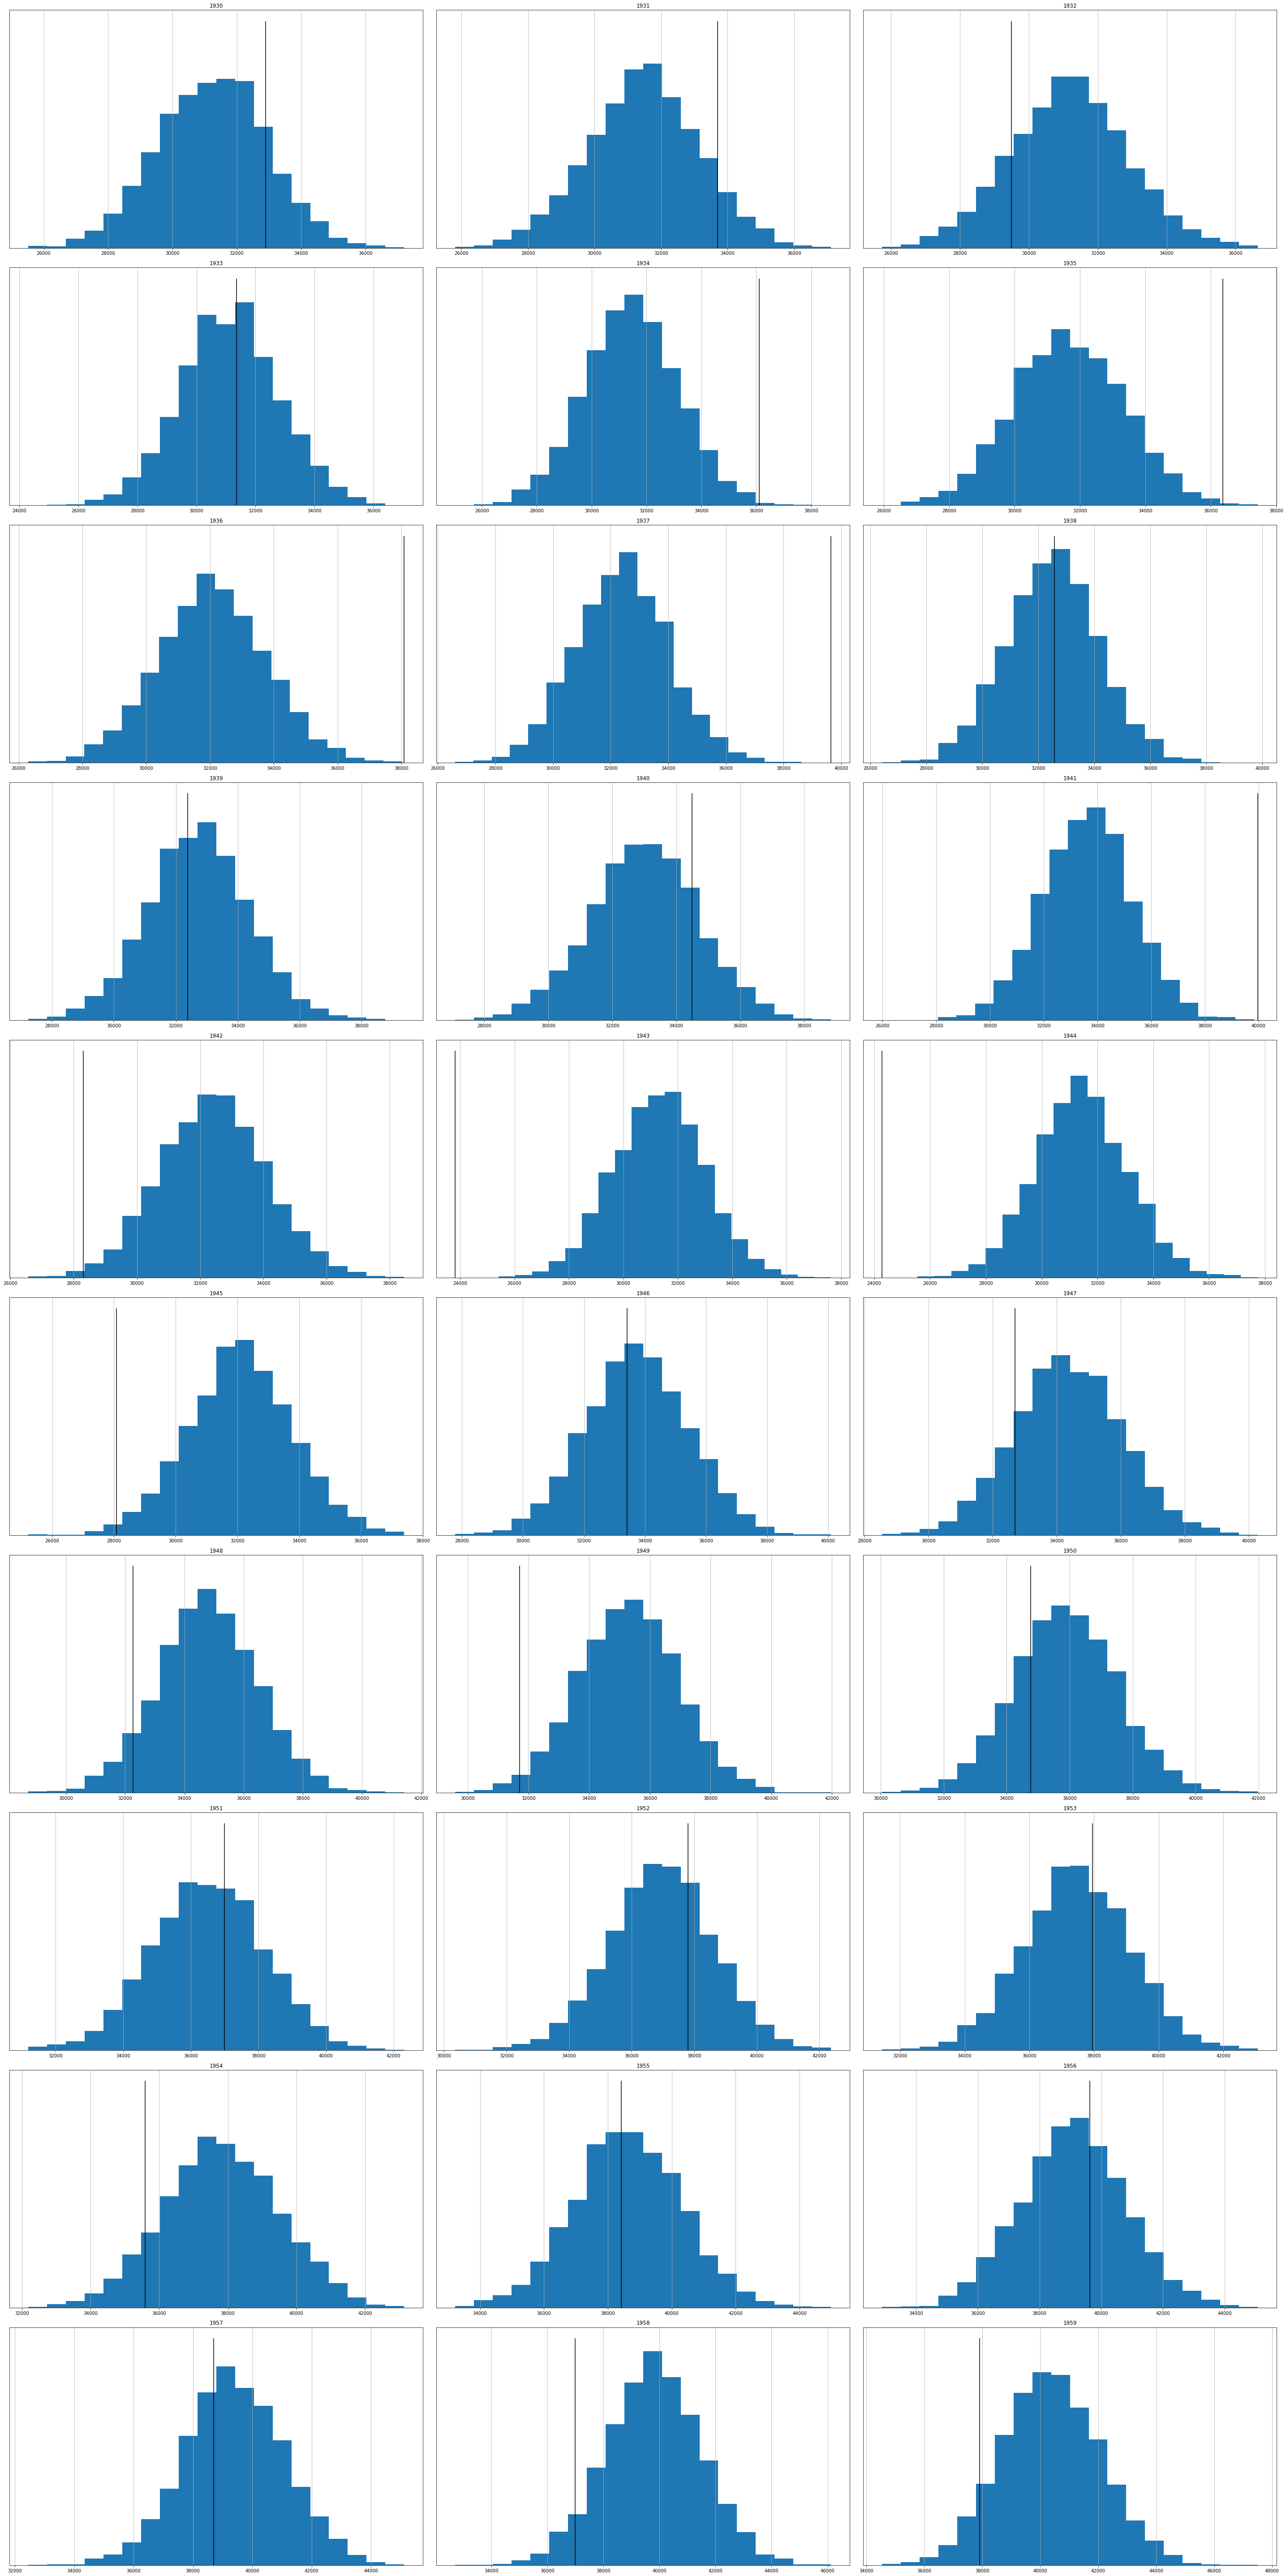

In [18]:
aaa = fit_height
fig, axes = plt.subplots(10, 3, figsize=(40, 80), sharey=True, squeeze=False)
axes_flat = axes.flatten()
tvn = df["Fatalities"].tolist()
for k, ax in enumerate(axes_flat):
    string = "death["+ str(k+1) + "]"
    ax.hist(fit_height[string], bins=20)
    ax.set_title(df['Year'][k])
    tv=tvn[k]
    ax.plot([tv, tv], [0, 700], color='black')
    ax.set_yticks([])
    ax.grid()
fig.tight_layout()
plt.show()

We can see that the model had come out with rather satisfying results. There are some major differances in years of WWII which obviously makes sense. This can be for a couple of reasons. First of all, actual data, gathered during the war, is probably not what it really was. And also, war has a huge influence on the data as well, even though it is data for USA and not from Europe where main fights took place.

<center><h1>SECOND MODEL</h1></center>

## Poisson distribution
Poisson distribution was chosen as a second model. It’s discrete probability distribution that expresses the probability of a given number of events (number of fatalities) occurring in a fixed interval of time or space (yearly) with a known constant mean rate and independently of the time since the last event. Many real issues are behaving similarly to Poisson distributed variables (such as: number of accidents, customers, Calls per hour at Call Center, Network failures per Week, etc.) and that is the reason why this model was chosen as well.

Modelling was started by proposing very simple model, with an assumption, that People deaths number $y_i$ has a Poisson distribution$$y_i\sim\mathrm{Poisson}(\lambda)$$with a rate $\lambda$ independent on year or miles flown.

Lets assume that 1500 people dying every day has very low probability (1500*365=547500). Following equation should be fullfilled: $$\lambda + 3\sqrt{\lambda} \approx 547500$$ which means that probability is less than 1%.

Firstly, variable $\sigma$ is calculated, which is used later on to find Prior. In next step prior check is conducted and values obtained in earlier steps are used to generate final results.

In [19]:
prob = 365*1500.
root_of_lam = np.polynomial.polynomial.polyroots([-1*prob,3.,1.])
lam_ub = np.round(root_of_lam[root_of_lam > 0]**2)
print(lam_ub[0])

545285.0


In [20]:
deaths = []
dta_cnt = []
for k in df['Fatalities']:  
    dta_cnt.append(-(1. + deaths.count(k)))
    deaths.append(k)
dta_cnt = np.array(dta_cnt)

In the next steps, parameter $\sigma$ is found of half normal distribution that cause most values to be spread between 0 and $\lambda$.

In [21]:
model = CmdStanModel(stan_file='prior_tune.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [22]:
data = dict(y_guess=np.array([np.log(100000)]), theta=np.array(lam_ub))
sim = model.sample(data=data,
                     iter_sampling=1, 
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=1052020)
sigma = np.round(sim.stan_variable('sigma')[0])
print(sigma)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



211693.0


Value printed above is $\sigma$


Function below was written to help robotise the process of testing this model while changing values in initial equation.

In [23]:
import math
def rounds(x):
    n = -1
    t = x
    while t>1:
        n += 1
        t = t/10
    dif = 10**n
    rou = int(math.ceil(x / dif)) * dif
    if rou-x>dif/2:
        rou = rou - dif/2
    return int(rou)

Code below prints figure of Poisson distribution.

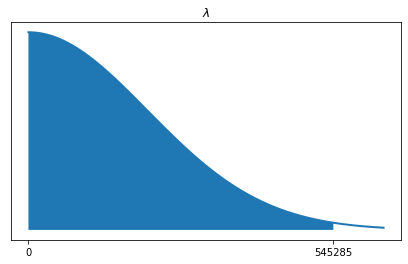

In [24]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2 = np.linspace(0, 3*sigma, 1000)
x4 = np.linspace(0, lam_ub[0], 1000)
ax2.plot(x2, 2*stats.norm.pdf(x2,scale=sigma), linewidth=2)
ax2.fill_between(x4, 2*stats.norm.pdf(x4, scale=sigma), 0)
ax2.set_yticks([])
ax2.set_xticks([0, lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

### Subsequently, we proceed to posterior inference and posterior predictive checks for second model

In [25]:
model_2 = CmdStanModel(stan_file='prior_pred.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [26]:
R = 1000
sim_2 = model_2.sample(data=dict(M = 1, sigma=int(sigma)),
                     iter_sampling=R, 
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=2902020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


C:\Users\aswat\AppData\Local\Temp\ipykernel_16080\1122288886.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax1.annotate('HalfNormal(0,' + str(np.int(sigma)) + ')', xy=(150,arr_y_loc), xytext=(200,1.5*arr_y_loc), arrowprops={'arrowstyle':'->'})


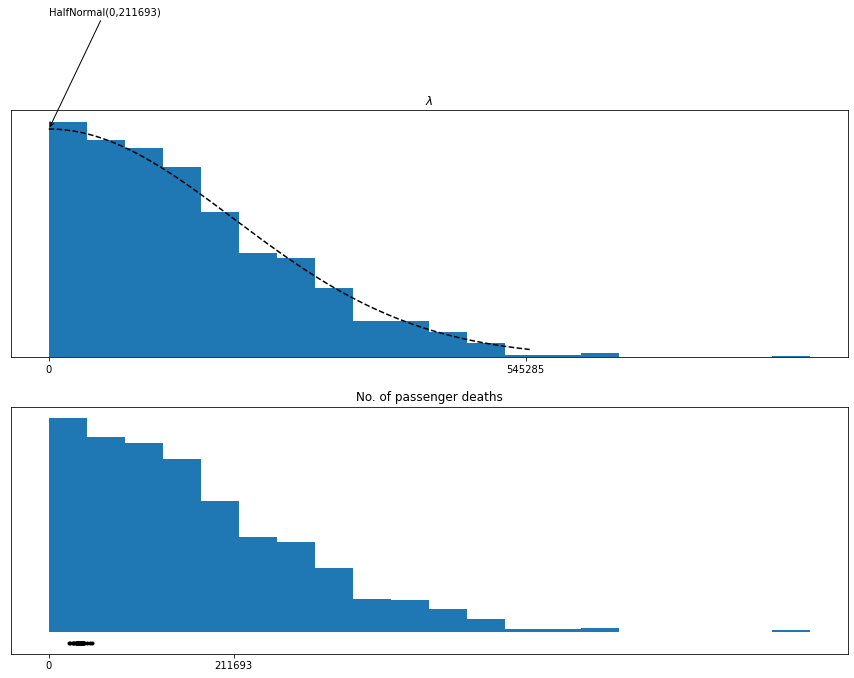

In [27]:
theta = sim_2.stan_variable('lambda')
y_sim = sim_2.stan_variable('y_sim')
fig, axes = plt.subplots(2, 1,figsize=(15, 10))
ax1 = axes[0]
ax1.hist(theta, bins=20, density=True)
x = np.linspace(0, rounds(lam_ub), 1000)
ax1.set_xticks([0, lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x, 2 * stats.norm.pdf(x, 0, sigma), color='black', linestyle='--')
arr_y_loc = 2 * stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,' + str(np.int(sigma)) + ')', xy=(150,arr_y_loc), xytext=(200,1.5*arr_y_loc), arrowprops={'arrowstyle':'->'})
ax2 = axes[1]
ax2.hist(y_sim.flatten(), density=True, bins=20, zorder=1)
ax2.scatter(deaths, 0.0000002 * dta_cnt, color='black', marker='.', zorder=2)
ax2.set_xticks([0,sigma])
ax2.set_yticks([])

ax2.set_title('No. of passenger deaths')
plt.show()

As it can be noticed on plot above, Prior prediction gave us really good results.


Below, main model is used to predict number of Fatalities in 1961.

In [28]:
model_car = CmdStanModel(stan_file='car_posterior.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [29]:
data_car = dict(M = len(df),
                y = np.round(df['Fatalities'].values),
                sigma=int(sigma))
fit_car = model_car.sample(data=data_car, seed=2902020)
lam = fit_car.stan_variable('lambda')
y_sim_c = fit_car.stan_variable('y_sim')

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [30]:
fit_car.diagnose()

'Processing csv files: C:\\Users\\aswat\\AppData\\Local\\Temp\\tmp_ju1um6i\\car_posterior-20220621232944_1.csv, C:\\Users\\aswat\\AppData\\Local\\Temp\\tmp_ju1um6i\\car_posterior-20220621232944_2.csv, C:\\Users\\aswat\\AppData\\Local\\Temp\\tmp_ju1um6i\\car_posterior-20220621232944_3.csv, C:\\Users\\aswat\\AppData\\Local\\Temp\\tmp_ju1um6i\\car_posterior-20220621232944_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

There were no issues with sampling.

Mean value of lambda and its 89% confidence interval:

In [31]:
mean_lam = np.mean(lam)
cinf_lam = az.hdi(lam, 0.89)
hdi_width = cinf_lam[1] - cinf_lam[0]

print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 35661.58
89% confidence interval: [ 35611.30 35710.70 ]


Ploting of results of final modeling.

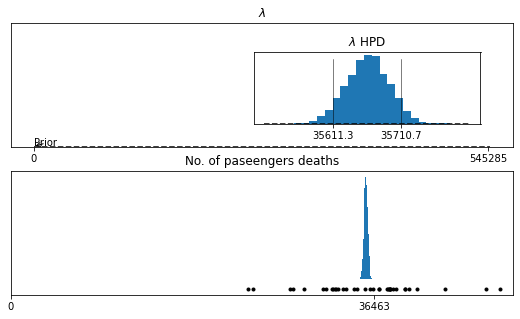

In [32]:
fig, axes = plt.subplots(2, 1,figsize=(9, 5))
ax1 = axes[0]
ax1.hist(lam, bins=20, density=True)
x = np.linspace(0, int(prob), 1000)

ax1.plot(x, 2 * stats.norm.pdf(x, 0, sigma), color='black', linestyle='--')
arr_y_loc = 2 * stats.norm.pdf(50, 0, sigma)
ax1.annotate(text='Prior', xy=(50, arr_y_loc), xytext=(100, 10 * arr_y_loc), arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0, lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm = plt.axes([0.5,0.6,0.35,0.2])
x_sm = np.linspace(cinf_lam[0]-hdi_width,cinf_lam[1]+hdi_width,200)
ax_sm.hist(lam, bins=20, density=True)
ax_sm.plot(x_sm, 2 * stats.norm.pdf(x_sm, 0, sigma), color='black', linestyle='--')
ax_sm.annotate(text='', xy=(cinf_lam[0] - .2, 0.2), xytext=(cinf_lam[1] + .2, 0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0], cinf_lam[0]], [0, 0.012], color='black', linestyle='-', linewidth=0.5)
ax_sm.plot([cinf_lam[1], cinf_lam[1]], [0, 0.012], color='black', linestyle='-', linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0], cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')


ax2 = axes[1]
ax2.hist(y_sim_c.flatten(), density=True, bins=20, zorder=1)
ax2.scatter(deaths, 0.0002 * dta_cnt, color='black', marker='.', zorder=2)
ax2.set_xticks([0, np.max(y_sim_c)])

ax2.set_yticks([])

ax2.set_title('No. of paseengers deaths')
plt.show()

In [33]:
median_y_sim = np.median(y_sim_c.flatten())
cinf_y_sim = az.hdi(y_sim_c.flatten(), 0.89)

print('Median of predicted accidents =', median_y_sim)
print('Confidence interval = [', *cinf_y_sim,']')

Median of predicted accidents = 35662.0
Confidence interval = [ 35352.0 35961.0 ]


Model has predicted relatively close value to real one, if a little lower than expected. Real value of vatalities in 1961 was 38091. 

Received value (35662) was about 6% lower than real value, so it's a quite good result. 

## Model Comparision

Finally, we proceeded to compare results from the models. We used waic and loo method to do this.

         rank           loo        p_loo        d_loo  weight           se  \
fit_poi     0 -17904.926323  5171.142451     0.000000     0.5  4367.018673   
fit_lin     1 -26219.186371  8045.116088  8314.260049     0.5   995.721345   

                 dse  warning loo_scale  
fit_poi     0.000000     True       log  
fit_lin  3913.802153     True       log  


e:\ProgramData\Anaconda3\envs\env_da\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
e:\ProgramData\Anaconda3\envs\env_da\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
e:\ProgramData\Anaconda3\envs\env_da\lib\site-packages\arv

<AxesSubplot:xlabel='Log'>

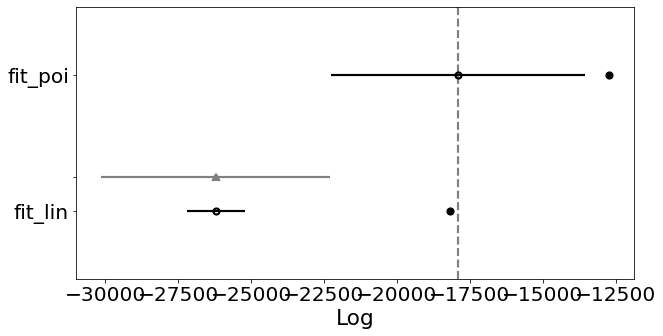

In [58]:
compare_dict = {'fit_lin': fit, 'fit_poi': fit_car}
loo_compare = az.compare(compare_dict, ic="loo")
print(loo_compare)
az.plot_compare(loo_compare, figsize=(10,5))

As a first comparision, LOO (leave one out) method was used. <br><br>
Analysis of comparision: <br>
rank - indicates which model is better (rank 0 is the best model) - Poisson model performed better than linear regression <br>
loo - Information Criterion, higher loo indicates higher out-of-sample predictive fit ("better model") - Poisson performes better <br>
p_loo - Estimated effective number of parameters <br>
d_loo - Relative difference between each loo <br>
weight - Relative weight for each model (probability of each model given data) <br>
se - Standard error of the IC estimate <br>
dse - Standard error of the difference in IC between each model and the top-ranked model. <br>

Analysis of figure: <br>
Open black dot - value of LOO <br>
Filled black dot - LOO + p_loo <br>
Line size - 2 * SE (Standard Error) <br>
Distance between filled black dots - d_loo <br>
Line with traingle - error of the best model showed for better comparision visualization

         rank          waic        p_waic       d_waic  weight            se  \
fit_poi     0 -44011.234982  31277.451111      0.00000     0.5  12212.628993   
fit_lin     1 -69726.704732  51552.634449  25715.46975     0.5  10274.529984   

                  dse  warning waic_scale  
fit_poi      0.000000     True        log  
fit_lin  11576.982149     True        log  


e:\ProgramData\Anaconda3\envs\env_da\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
e:\ProgramData\Anaconda3\envs\env_da\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
e:\ProgramData\Anaconda3\envs\env_da\lib\site-packages\arviz\stats\stats.py:267: RuntimeWarning: divide by zero encountered in log
  score += np.log(np.dot(exp_ic_i[i], w_full))
e:\ProgramData\Anaconda3\envs\env_da\lib\site-packages\arviz\stats\stats.py:275: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] += (exp_ic_i[i, k] - exp_ic_i[i, km1]) / np.dot(exp_ic_i[i], w_

<AxesSubplot:xlabel='Log'>

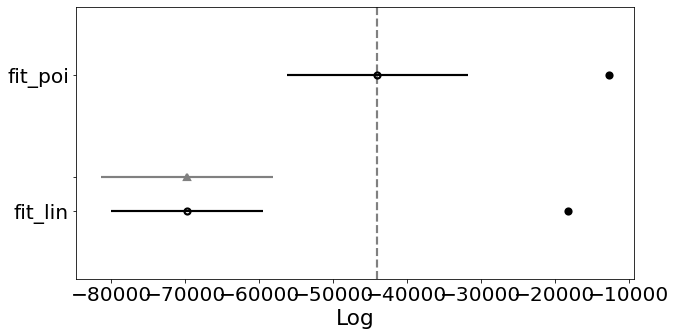

In [59]:
waic_compare = az.compare(compare_dict, ic="waic")
print(waic_compare)
az.plot_compare(waic_compare, figsize=(10,5))

WAIC (widely applicable information criterion) method was used in second comparision. <br><br>
Analysis of comparision: <br>
rank - indicates which model is better (rank 0 is the best model) - Poisson model performed better than linear regression <br>
waic - Information Criterion, higher waic indicates higher out-of-sample predictive fit ("better model") - Poisson performes better <br>
p_waic - Estimated effective number of parameters <br>
d_waic - Relative difference between each waic <br>
weight - Relative weight for each model (probability of each model given data) <br>
se - Standard error of the IC estimate <br>
dse - Standard error of the difference in IC between each model and the top-ranked model. <br>

Analysis of visualisation: <br>
Open black dot - value of waic <br>
Filled black dot - waic + p_waic <br>
Line size - 2 * SE (Standard Error) <br>
Distance between filled black dots - d_waic <br>
Line with traingle - error of the best model showed for better comparision visualization